In [1]:
%load_ext watermark
%watermark


Last updated: 2023-05-04T22:17:46.204269-05:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.13.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import spacy
from scipy import stats

import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact

import unidecode

import re

import pickle

import sys

from progressbar import ProgressBar

import matplotlib.pyplot as plt

from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer

from ast import literal_eval

from wordcloud import WordCloud

from surprise import KNNBasic, SVD, NMF, Dataset, Reader
from surprise.model_selection import train_test_split

import nltk  # Natural language toolkit
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')  # stopwords
stopwords = stopwords.words('english')

# nlp = spacy.load('es_core_news_lg')  # large
# nlp = spacy.load('es_core_news_sm') # small
# nlp = spacy.load('en_core_web_lg') # large
nlp = spacy.load('en_core_web_sm')  # small

sns.set(font_scale=0.7)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ereye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Resume

The dataset files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. This dataset captures feature points like cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts, and vote averages.

These feature points could be potentially used to train your machine learning models for content and collaborative filtering.

This dataset consists of the following files:

- movies_metadata.csv: This file contains information on ~45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, genre, revenue, release dates, languages, production countries, and companies.
- keywords.csv: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.
- credits.csv: Consists of Cast and Crew Information for all the movies. Available in the form of a stringified JSON Object.
- links.csv: This file contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
- links_small.csv: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.
- ratings_small.csv: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset comprises of 26 million ratings and 750,000 tag applications, from 270,000 users on all the 45,000 movies in this dataset. It can be accessed from the official GroupLens website.

https://grouplens.org/datasets/movielens/latest/

Note: The subset dataset used in today's tutorial can be downloaded from: https://www.kaggle.com/rounakbanik/the-movies-dataset

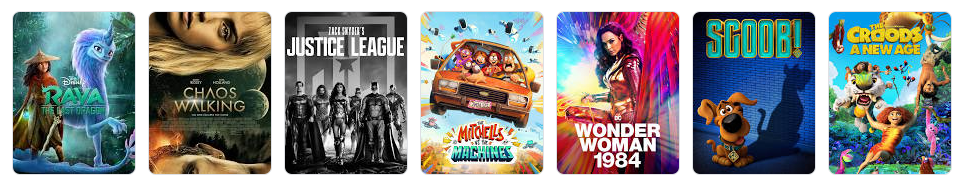

# Data Collection

In [3]:
item_df = pd.read_csv('resources/movies_metadata.csv', low_memory=False)
item_df.set_index(keys='id', inplace=True)

item_df.drop(labels=['homepage', 'imdb_id', 'poster_path'], axis=1, inplace=True)

# Rename the columns
#

item_df.head()


,adult,belongs_to_collection,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,
862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
credits_df = pd.read_csv('resources/credits.csv')

# Rename the columns
#

credits_df.head()


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [5]:
keywords_df = pd.read_csv('resources/keywords.csv')

# Rename the columns
#

keywords_df.head()


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
user_ratings_df = pd.read_csv('resources/ratings_small.csv')

user_ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

user_ratings_df.head()


,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Se eliminan los registros completamente `vacíos` y los `duplicados`.

In [7]:
n = item_df.shape[0]

item_df.dropna(axis=0, how='all', inplace=True)
item_df.drop_duplicates(keep='first', inplace=True)

# Eliminar por index o columnas específicas
item_df = item_df[~item_df.index.duplicated(keep='first')]

print(f'Eliminados: {n - item_df.shape[0]}')
item_df.shape


Eliminados: 30


(45436, 20)

In [8]:
# Remove rows with bad IDs.
item_df.drop(labels=['1997-08-20', '2012-09-29', '2014-01-01'], axis=0, inplace=True)

item_df.index = item_df.index.astype(int)
credits_df.id = credits_df.id.astype(int)
keywords_df.id = keywords_df.id.astype(int)

# resources
df = item_df.merge(right=credits_df, how='inner', left_index=True, right_on='id', validate='1:m')
df.drop(labels='id', axis=1, inplace=True)

df = df.merge(right=keywords_df, how='inner', left_index=True, right_on='id', validate='1:m')
df.drop(labels='id', axis=1, inplace=True)

df.head(3)


,adult,belongs_to_collection,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
4342,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 240, 'name': 'underdog'}, {'id': 378, ..."
12947,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 1361, 'name': 'salesclerk'}, {'id': 17..."
17,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na..."


In [9]:
# Ejecutar siempre que se eliminen datos en df
def sync_user_ratings():
    # Se eliminan los items que contiene user_ratings_df pero no df
    ii = set(user_ratings_df.item_id) - set(df.index)
    return user_ratings_df[~user_ratings_df.item_id.isin(ii)]


user_ratings_df = sync_user_ratings()
user_ratings_df.head()


,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18945 entries, 4342 to 14102
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18945 non-null  object 
 1   belongs_to_collection  1828 non-null   object 
 2   budget                 18945 non-null  object 
 3   genres                 18945 non-null  object 
 4   original_language      18944 non-null  object 
 5   original_title         18945 non-null  object 
 6   overview               18549 non-null  object 
 7   popularity             18944 non-null  object 
 8   production_companies   18944 non-null  object 
 9   production_countries   18944 non-null  object 
 10  release_date           18912 non-null  object 
 11  revenue                18944 non-null  float64
 12  runtime                18825 non-null  float64
 13  spoken_languages       18944 non-null  object 
 14  status                 18917 non-null  object 
 15  tagl

# Data Transform

In [11]:
cardinality_resume = pd.DataFrame(columns=['DATA_TYPE',
                                           'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                           'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

for column in df.columns:
    n_per_value = df[column].value_counts(dropna=False)
    more_common_qty = n_per_value.iloc[0]
    less_common_qty = n_per_value.iloc[-1]

    cardinality_resume.loc[column] = {'DATA_TYPE': df[column].dtype,
                                      'MORE_COMMON_VAL': n_per_value.index[0],
                                      'MORE_COMMON_QTY': more_common_qty,
                                      'MORE_COMMON_PERC': round(more_common_qty * 100 / (1.0 * len(df)), 3),
                                      'LESS_COMMON_VAL': n_per_value.index[-1],
                                      'LESS_COMMON_QTY': less_common_qty,
                                      'LESS_COMMON_PERC': round(less_common_qty * 100 / (1.0 * len(df)), 3)}

cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
adult,object,False,18941,99.979,True,4,0.021
belongs_to_collection,object,NaN,17117,90.351,"{'id': 152918, 'name': 'Mister Blot Collection...",1,0.005
budget,object,0,15143,79.931,1254040,1,0.005
genres,object,"[{'id': 18, 'name': 'Drama'}]",2139,11.291,"[{'id': 10402, 'name': 'Music'}, {'id': 35, 'n...",1,0.005
original_language,object,en,13460,71.048,ne,1,0.005
original_title,object,Hamlet,6,0.032,Les Transmutations imperceptibles,1,0.005
overview,object,NaN,396,2.090,This shows a prince entering upon the stage of...,1,0.005
popularity,object,1e-06,23,0.121,0.071782,1,0.005
production_companies,object,[],4851,25.606,"[{'name': 'Hu Tong Communications', 'id': 1452...",1,0.005
production_countries,object,"[{'iso_3166_1': 'US', 'name': 'United States o...",7471,39.435,"[{'iso_3166_1': 'PL', 'name': 'Poland'}, {'iso...",1,0.005


In [12]:
cardinality_resume = cardinality_resume.loc[(cardinality_resume.MORE_COMMON_PERC > 90.) |
                                            ((cardinality_resume.MORE_COMMON_PERC > 25.) & (cardinality_resume.MORE_COMMON_VAL.isna()))]
cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
adult,object,False,18941,99.979,True,4,0.021
belongs_to_collection,object,NaN,17117,90.351,"{'id': 152918, 'name': 'Mister Blot Collection...",1,0.005
status,object,Released,18750,98.971,Canceled,1,0.005
tagline,object,NaN,10445,55.133,They're sexy. They're fearless. They're... Fit...,1,0.005
video,object,False,18916,99.847,NaN,1,0.005


In [13]:
for col in cardinality_resume.index:
    display(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------------------')


adult
False    0.999789
True     0.000211
Name: proportion, dtype: float64

----------------------------------


belongs_to_collection
NaN                                                                                                                                                                             0.903510
{'id': 37261, 'name': 'The Carry On Collection', 'poster_path': '/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg', 'backdrop_path': '/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg'}                        0.000528
{'id': 224026, 'name': 'Monster High Collection', 'poster_path': '/z230ua2CDBkPAQCOUmENphU9Hm9.jpg', 'backdrop_path': '/kDsPcm1Qx5zjPNAZ80dBSHdTowH.jpg'}                       0.000528
{'id': 421566, 'name': 'Totò Collection', 'poster_path': '/4ayJsjC3djGwU9eCWUokdBWvdLC.jpg', 'backdrop_path': '/jaUuprubvAxXLAY5hUfrNjxccUh.jpg'}                               0.000475
{'id': 97919, 'name': 'The Love Comes Softly Collection', 'poster_path': '/AoO3BPRgLa044ppf0oNWqF7t4SI.jpg', 'backdrop_path': None}                                             0.000422
                                                     

----------------------------------


status
Released           0.989707
Rumored            0.005226
Post Production    0.002534
NaN                0.001478
Planned            0.000528
In Production      0.000475
Canceled           0.000053
Name: proportion, dtype: float64

----------------------------------


tagline
NaN                                                                                                                                                 0.551333
Who is John Galt?                                                                                                                                   0.000158
BEYOND THE GLAMOUR OF CANNES LIES THE NAKED TRUTH OF MOVIEMAKING.                                                                                   0.000106
Pledging was hell ... Getting in was murder                                                                                                         0.000106
What are friends for?                                                                                                                               0.000106
                                                                                                                                                      ...   
Johnny Weismuller is back again!                  

----------------------------------


video
False    0.998469
True     0.001478
NaN      0.000053
Name: proportion, dtype: float64

----------------------------------


- Se eliminarán las columnas `adult`, `belongs_to_collection`, `status`, `tagline` y `video` al tener más del `90%` un valor repetido.

In [14]:
df.drop(labels=['adult', 'belongs_to_collection', 'status', 'tagline', 'video'], axis=1, inplace=True)


# Outliers

In [15]:
def build_outliers_resume():
    resume = pd.DataFrame(columns=['OUTLIER', 'FREQUENCY', 'UNIQUE_OUTLIERS', 'UNIQUE_VALUES', 'DATA_TYPE'])
    resume.OUTLIER = resume.OUTLIER.astype(bool)

    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        outliers = df[zcores > 3][col].values
        n_outliers = len(outliers)

        resume.loc[col] = {'OUTLIER': False if n_outliers == 0 else True,
                           'FREQUENCY': n_outliers,
                           'UNIQUE_OUTLIERS': set(outliers),
                           'UNIQUE_VALUES': df[col].unique(),
                           'DATA_TYPE': df[col].dtype}

    return resume


build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
budget,True,390,"{72000000.0, 80000000.0, 200000000.0, 64000000...","[0.0, 16000000.0, 60000000.0, 58000000.0, 4400...",float64
popularity,False,0,{},"[11.7129, 3.859495, 17.924927, 6.677277, 5.430...",float64
revenue,False,0,{},"[0.0, 81452156.0, 187436818.0, 11348324.0, 136...",float64
runtime,False,0,{},"[101.0, 127.0, 170.0, 88.0, 78.0, 192.0, 119.0...",float64
vote_average,False,0,{},"[6.5, 6.1, 7.7, 6.2, 5.7, 7.1, 7.8, 7.2, 5.4, ...",float64
vote_count,False,0,{},"[92.0, 34.0, 1886.0, 141.0, 210.0, 423.0, 72.0...",float64


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.
- Analizar detalladamente cada columna, a no todas se le aplican los cambios. 

In [16]:
ops = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
sts = {col: {'mean': df[col].mean(), 'std': df[col].std()} for col in ops}

for col in ops:
    zcores = np.abs((df[col] - sts[col]['mean']) / sts[col]['std'])
    idx = zcores[zcores > 3].index
    df.loc[idx, col] = np.nan

build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
budget,False,0,{},"[0.0, 16000000.0, nan, 58000000.0, 44000000.0,...",float64
popularity,False,0,{},"[11.7129, 3.859495, 17.924927, 6.677277, 5.430...",float64
revenue,False,0,{},"[0.0, 81452156.0, 187436818.0, 11348324.0, 136...",float64
runtime,False,0,{},"[101.0, 127.0, 170.0, 88.0, 78.0, 192.0, 119.0...",float64
vote_average,False,0,{},"[6.5, 6.1, 7.7, 6.2, 5.7, 7.1, 7.8, 7.2, 5.4, ...",float64
vote_count,False,0,{},"[92.0, 34.0, nan, 141.0, 210.0, 423.0, 72.0, 1...",float64


# Imputers

In [17]:
def build_imputers_resume():
    resume = pd.DataFrame()

    for column in df.columns:
        resume.loc[column, 'TYPE'] = df[column].dtype
        resume.loc[column, 'VALUES'] = str(df[column].unique())
        resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
        resume.loc[column, 'NULL_COUNT'] = df[column].isnull().sum(axis=0)

    return resume


build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
budget,float64,[0.0000000e+00 1.6000000e+07 nan 5.8...,605.0,390.0
genres,object,"[""[{'id': 10749, 'name': 'Romance'}, {'id': 35...",2384.0,0.0
original_language,object,['en' 'fr' 'fa' 'nl' 'de' 'cn' 'it' 'zh' 'es' ...,77.0,1.0
original_title,object,['Grumpier Old Men' 'Waiting to Exhale' 'Heat'...,18354.0,0.0
overview,object,"[""A family wedding reignites the ancient feud ...",18324.0,396.0
popularity,float64,[11.7129 3.859495 17.924927 ... 1.092445 ...,18266.0,76.0
production_companies,object,"[""[{'name': 'Warner Bros.', 'id': 6194}, {'nam...",10247.0,1.0
production_countries,object,"[""[{'iso_3166_1': 'US', 'name': 'United States...",1297.0,1.0
release_date,object,['1995-12-22' '1995-12-15' '1995-11-22' ... '1...,10402.0,33.0
revenue,float64,[0.00000000e+00 8.14521560e+07 1.87436818e+08 ...,2712.0,273.0


Se eliminan los registros de las columnas que no tienen sentidos `imputarlas` (`variable objetivo`, etc).

In [18]:
#

user_ratings_df = sync_user_ratings()


In [19]:
ops = {'budget': df['budget'].median(),
       'genres': '',
       'original_language': df['original_language'].mode()[0],
       'original_title': '',
       'overview': '',
       'popularity': df['popularity'].median(),
       'production_companies': '',
       'production_countries': '',
       'release_date': '1900-01-01',
       'revenue': df['revenue'].median(),
       'runtime': df['runtime'].median(),
       'spoken_languages': '',
       'title': '',
       'vote_average': df['vote_average'].median(),
       'vote_count': df['vote_count'].median(),
       'cast': '',
       'crew': '',
       'keywords': ''}

for k in ops:
    df[k].fillna(value=ops[k], inplace=True)

build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
budget,float64,[0.0000000e+00 1.6000000e+07 5.8000000e+07 4.4...,604.0,0.0
genres,object,"[""[{'id': 10749, 'name': 'Romance'}, {'id': 35...",2384.0,0.0
original_language,object,['en' 'fr' 'fa' 'nl' 'de' 'cn' 'it' 'zh' 'es' ...,76.0,0.0
original_title,object,['Grumpier Old Men' 'Waiting to Exhale' 'Heat'...,18354.0,0.0
overview,object,"[""A family wedding reignites the ancient feud ...",18324.0,0.0
popularity,float64,[11.7129 3.859495 17.924927 ... 1.092445 ...,18265.0,0.0
production_companies,object,"[""[{'name': 'Warner Bros.', 'id': 6194}, {'nam...",10247.0,0.0
production_countries,object,"[""[{'iso_3166_1': 'US', 'name': 'United States...",1297.0,0.0
release_date,object,['1995-12-22' '1995-12-15' '1995-11-22' ... '1...,10402.0,0.0
revenue,float64,[0.00000000e+00 8.14521560e+07 1.87436818e+08 ...,2711.0,0.0


# IMDb (Internet Movie database)

Media de los votos.

In [20]:
C = df.vote_average.mean()
C


5.638474531538664

 Mínimo de votos requeridos.

In [21]:
m = df.vote_count.quantile(q=0.90)
m


137.0

In [22]:
q_items = item_df[['title', 'vote_count', 'vote_average']].loc[item_df.vote_count >= m]
q_items.head()


,title,vote_count,vote_average
id,,,
862,Toy Story,5415.0,7.7
8844,Jumanji,2413.0,6.9
11862,Father of the Bride Part II,173.0,5.7
949,Heat,1886.0,7.7
11860,Sabrina,141.0,6.2


Cálculo de las valoraciones.

In [23]:
def weighted_rating(x):
    v, R = x.vote_count, x.vote_average

    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)


q_items['score'] = q_items.apply(weighted_rating, axis=1)
q_items.sort_values(by='score', ascending=False, inplace=True)
q_items.head(10)


,title,vote_count,vote_average,score
id,,,,
19404,Dilwale Dulhania Le Jayenge,661.0,9.1,8.505728
278,The Shawshank Redemption,8358.0,8.5,8.453852
238,The Godfather,6024.0,8.5,8.436369
155,The Dark Knight,12269.0,8.3,8.270609
550,Fight Club,9678.0,8.3,8.262850
680,Pulp Fiction,8670.0,8.3,8.258598
424,Schindler's List,4436.0,8.3,8.220265
244786,Whiplash,4376.0,8.3,8.219205
129,Spirited Away,3968.0,8.3,8.211174


# Memory-Based

## Content-Based

### User-Profile

Se obtienen las características más importantes de los recursos.

In [24]:
profile_df = pd.DataFrame(index=df.index)


def data_array_to_columns(column, prefix, max_col):
    def get_names(x):
        try:
            return [i['name'].lower() for i in literal_eval(x)]
        except:
            return []

    values = df[column].apply(get_names).explode()
    values = values[values.notnull()]
    unique_values = values.unique()

    display(unique_values, f'[{len(unique_values)}]')

    # Fill DataFrame
    bar = ProgressBar(maxval=len(values)).start()
    i = 0

    for index, row in values.items():
        profile_df.loc[index, f'{prefix}_{row}'] = 1

        i += 1
        bar.update(i)

    bar.finish()

    # df.drop(labels=column, axis=1, inplace=True)
    #################

    new_columns = [f'{prefix}_{x}' for x in unique_values]

    # Keep best columns
    if max_col != -1 and max_col < len(new_columns):
        best_cols = profile_df[new_columns].count().sort_values(ascending=False)
        new_columns = best_cols[:max_col].index.to_list()
        drop_cols = best_cols[max_col:].index.to_list()

        new_columns.append(f'{prefix}_other')
        profile_df[new_columns[-1]] = profile_df[drop_cols].any(axis=1).values

        profile_df.drop(labels=drop_cols, axis=1, inplace=True)
    #################

    profile_df[new_columns] = profile_df[new_columns].fillna(value=0)
    profile_df[new_columns] = profile_df[new_columns].astype(int)

    return new_columns


new_columns = data_array_to_columns(column='genres', prefix='genre', max_col=-1)
new_columns += data_array_to_columns(column='production_countries', prefix='country', max_col=10)
new_columns += data_array_to_columns(column='spoken_languages', prefix='lang', max_col=5)

profile_df[new_columns].head()


array(['romance', 'comedy', 'drama', 'action', 'crime', 'thriller',
       'horror', 'family', 'animation', 'adventure', 'history', 'fantasy',
       'science fiction', 'mystery', 'documentary', 'music', 'war',
       'foreign', 'western', 'tv movie'], dtype=object)

'[20]'

100% |########################################################################|


array(['united states of america', 'germany', 'france', 'italy',
       'united kingdom', 'spain', 'australia', 'canada', 'japan', 'iran',
       'netherlands', 'belgium', 'hong kong', 'ireland', 'croatia',
       'russia', 'macedonia', 'austria', 'switzerland', 'taiwan',
       'new zealand', 'mexico', 'poland', 'peru', 'cuba', 'china',
       'south africa', 'denmark', 'portugal', 'finland', 'sweden',
       'argentina', 'tunisia', 'iceland', 'south korea', 'serbia',
       'hungary', 'czech republic', 'india', 'greece', 'congo', 'senegal',
       'burkina faso', 'romania', 'philippines', 'vietnam',
       'trinidad and tobago', 'algeria', 'luxembourg', 'botswana',
       'aruba', 'turkey', 'israel', 'norway', 'czechoslovakia',
       'bosnia and herzegovina', 'slovenia', 'libyan arab jamahiriya',
       'brazil', 'thailand', 'malta', 'martinique', 'liechtenstein',
       'georgia', 'armenia', 'morocco', 'egypt', 'singapore', 'mongolia',
       'chile', 'bolivia', 'monaco', 'bhutan',

'[143]'

C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profile_df.loc[index, f'{prefix}_{row}'] = 1
C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profile_df.loc[index, f'{prefix}_{row}'] = 1
C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

array(['english', 'español', 'français', 'deutsch', 'latin', 'nederlands',
       '广州话 / 廣州話', 'pусский', 'magyar', 'فارسی', 'dansk', '', '日本語',
       '普通话', 'italiano', 'hrvatski', 'bosanski', 'română',
       'bahasa indonesia', 'bahasa melayu', 'shqip', 'svenska',
       'עִבְרִית', 'český', '한국어/조선말', 'polski', 'gaeilge', 'norsk',
       'tiếng việt', 'हिन्दी', 'العربية', 'català', 'íslenska',
       'afrikaans', 'srpski', 'বাংলা', 'português', 'wolof', 'cymraeg',
       'ภาษาไทย', 'latviešu', 'kiswahili', 'türkçe', 'ελληνικά',
       'український', 'slovenčina', 'no language', 'suomi', 'isizulu',
       'somali', 'azərbaycan', 'ქართული', 'اردو', 'galego', 'ਪੰਜਾਬੀ',
       'kinyarwanda', 'қазақ', 'پښتو', 'eesti', 'slovenščina', 'euskera',
       'bamanankan', 'fulfulde', 'தமிழ்', 'български език',
       'lietuvi\x9akai', 'తెలుగు', 'esperanto', '??????', '?????',
       'ozbek', 'hausa'], dtype=object)

'[72]'

C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profile_df.loc[index, f'{prefix}_{row}'] = 1
C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profile_df.loc[index, f'{prefix}_{row}'] = 1
C:\Users\ereye\AppData\Local\Temp\ipykernel_22540\725783168.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

,genre_romance,genre_comedy,genre_drama,genre_action,genre_crime,genre_thriller,genre_horror,genre_family,genre_animation,genre_adventure,...,country_spain,country_india,country_russia,country_other,lang_english,lang_français,lang_deutsch,lang_español,lang_italiano,lang_other
4342,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12947,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
474,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
256,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [25]:
profile_df.shape


(18945, 37)

Se genera user_ratings_pivot.

In [26]:
user_ratings_pivot = user_ratings_df.pivot_table(values='rating', index='item_id', columns='user_id',
                                                 aggfunc=np.mean, fill_value=0)

# Se agregan los items que se encuentran en df pero no en user_ratings_df
ii = list(set(df.index) - set(user_ratings_df.item_id))
user_ratings_pivot = pd.concat([user_ratings_pivot, pd.DataFrame(index=ii)], axis=0)
user_ratings_pivot.fillna(value=.0, inplace=True)

# Se ordenan las filas
user_ratings_pivot.sort_index(inplace=True)

user_ratings_pivot


,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
if profile_df.shape[0] != user_ratings_pivot.shape[0]:
    raise ValueError('Error...')


Se construye user-profile.

In [28]:
user_ratings_arr = user_ratings_pivot.to_numpy()
profile_arr = profile_df.to_numpy()

item_len = user_ratings_arr.shape[0]
user_len = user_ratings_arr.shape[1]
feature_len = profile_arr.shape[1]

user_profile_arr = np.zeros(shape=(user_len, feature_len))

bar = ProgressBar(maxval=user_len).start()

for u in range(0, user_len):
    ratings = np.zeros(shape=(item_len, feature_len))

    for i in range(0, item_len):
        profile = profile_arr[i]
        ratings[i] = user_ratings_arr[i, u] * profile

    user_profile_arr[u] = np.sum(ratings, axis=0)
    bar.update(u)

bar.finish()

user_profile_arr.shape


100% |########################################################################|


(671, 37)

In [29]:
user_profile_df = pd.DataFrame(data=user_profile_arr, index=user_ratings_pivot.columns, columns=profile_df.columns)
user_profile_df.head(10)


,genre_romance,genre_comedy,genre_drama,genre_action,genre_crime,genre_thriller,genre_horror,genre_family,genre_animation,genre_adventure,...,country_japan,country_russia,country_india,country_other,lang_english,lang_español,lang_français,lang_deutsch,lang_italiano,lang_other
1,10.0,16.0,30.0,6.0,7.5,6.5,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,4.0,38.5,0.0,5.0,0.0,0.0,12.0
2,66.0,103.0,135.0,34.0,43.0,49.0,11.0,43.0,10.0,22.0,...,4.0,3.0,0.0,15.0,201.0,15.0,29.0,19.0,11.0,35.0
3,25.5,43.0,81.0,18.0,24.5,26.5,10.0,16.5,3.5,11.5,...,10.5,0.0,3.0,22.5,112.0,10.0,20.5,14.0,3.0,23.0
4,156.0,228.0,365.0,117.0,92.0,139.0,63.0,80.0,18.0,103.0,...,11.0,0.0,0.0,28.0,614.0,50.0,74.0,13.0,43.0,90.0
5,81.0,113.0,169.0,52.0,49.0,88.0,25.5,16.0,8.0,25.5,...,20.0,0.0,4.5,34.5,219.0,15.5,33.0,16.0,12.5,61.0
6,22.5,59.0,65.5,17.5,21.0,36.5,6.0,7.0,0.0,9.0,...,0.5,0.0,4.0,12.0,110.5,5.5,5.5,5.0,0.0,13.5
7,56.0,93.0,143.0,44.0,41.0,52.0,19.0,36.0,11.0,24.0,...,3.0,3.0,0.0,24.0,216.0,20.0,36.0,12.0,12.0,24.0
8,52.0,103.5,157.0,60.0,61.0,86.5,20.0,37.5,7.5,38.0,...,20.5,0.0,0.0,54.5,241.0,29.0,24.5,16.5,14.0,87.0
9,26.0,55.0,58.0,33.0,11.0,36.0,7.0,13.0,9.0,23.0,...,0.0,0.0,0.0,13.0,127.0,15.0,29.0,12.0,12.0,28.0
10,26.0,62.0,91.0,25.0,14.0,54.0,16.0,17.0,0.0,15.0,...,0.0,0.0,0.0,17.0,121.0,18.0,15.0,11.0,12.0,24.0


Se normalizan los datos.

In [30]:
user_profile_df = user_profile_df.apply(lambda x: x/x.sum(), axis=1)
user_profile_df.head(10)


,genre_romance,genre_comedy,genre_drama,genre_action,genre_crime,genre_thriller,genre_horror,genre_family,genre_animation,genre_adventure,...,country_japan,country_russia,country_india,country_other,lang_english,lang_español,lang_français,lang_deutsch,lang_italiano,lang_other
1,0.048900,0.078240,0.146699,0.029340,0.036675,0.031785,0.000000,0.000000,0.000000,0.009780,...,0.000000,0.000000,0.000000,0.019560,0.188264,0.000000,0.024450,0.000000,0.000000,0.058680
2,0.056027,0.087436,0.114601,0.028862,0.036503,0.041596,0.009338,0.036503,0.008489,0.018676,...,0.003396,0.002547,0.000000,0.012733,0.170628,0.012733,0.024618,0.016129,0.009338,0.029711
3,0.037834,0.063798,0.120178,0.026706,0.036350,0.039318,0.014837,0.024481,0.005193,0.017062,...,0.015579,0.000000,0.004451,0.033383,0.166172,0.014837,0.030415,0.020772,0.004451,0.034125
4,0.047882,0.069982,0.112032,0.035912,0.028238,0.042664,0.019337,0.024555,0.005525,0.031614,...,0.003376,0.000000,0.000000,0.008594,0.188459,0.015347,0.022713,0.003990,0.013198,0.027624
5,0.057305,0.079943,0.119561,0.036788,0.034666,0.062257,0.018040,0.011319,0.005660,0.018040,...,0.014149,0.000000,0.003184,0.024407,0.154935,0.010966,0.023346,0.011319,0.008843,0.043155
6,0.039096,0.102520,0.113814,0.030408,0.036490,0.063423,0.010426,0.012163,0.000000,0.015639,...,0.000869,0.000000,0.006950,0.020851,0.192007,0.009557,0.009557,0.008688,0.000000,0.023458
7,0.047619,0.079082,0.121599,0.037415,0.034864,0.044218,0.016156,0.030612,0.009354,0.020408,...,0.002551,0.002551,0.000000,0.020408,0.183673,0.017007,0.030612,0.010204,0.010204,0.020408
8,0.033441,0.066559,0.100965,0.038585,0.039228,0.055627,0.012862,0.024116,0.004823,0.024437,...,0.013183,0.000000,0.000000,0.035048,0.154984,0.018650,0.015756,0.010611,0.009003,0.055949
9,0.035374,0.074830,0.078912,0.044898,0.014966,0.048980,0.009524,0.017687,0.012245,0.031293,...,0.000000,0.000000,0.000000,0.017687,0.172789,0.020408,0.039456,0.016327,0.016327,0.038095
10,0.034211,0.081579,0.119737,0.032895,0.018421,0.071053,0.021053,0.022368,0.000000,0.019737,...,0.000000,0.000000,0.000000,0.022368,0.159211,0.023684,0.019737,0.014474,0.015789,0.031579


Se obtienen los `id` de los recursos recomendados por para cada usuario.

In [31]:
user_profile_arr = user_profile_df.to_numpy()

no_recom = 20
recommender_arr = np.zeros(shape=(user_len, no_recom))

bar = ProgressBar(maxval=user_len).start()

for u in range(0, user_len):
    matrix = user_profile_arr[u] * profile_arr
    matrix = np.sum(matrix, axis=1)

    n = 0
    while n < no_recom:
        i = np.argmax(matrix)
        max_value = matrix[i]
        matrix[i] = -1

        # Verifica que no sea un recurso ya obtenido por el usuario.
        if user_ratings_arr[i, u] != 0:
            continue

        recommender_arr[u, n] = df.iloc[i].name
        n += 1

    bar.update(u)

bar.finish()

recommender_df = pd.DataFrame(data=recommender_arr, index=user_ratings_pivot.columns).astype(int)
recommender_df.head(10)


100% |########################################################################|


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,6749,1893,11229,46064,2593,9370,19987,25002,19947,1652,388,44230,4827,22554,7221,23918,20027,29609,6791,2067
2,1893,6749,10963,1652,9370,2593,23918,19987,2191,2067,11279,25061,15115,11229,7221,11878,25002,9748,26719,19947
3,46064,6749,2593,4827,26719,19987,29609,1893,22554,25002,1519,40081,11292,1652,2419,1475,9370,3701,11279,19947
4,1893,6749,2593,10963,1652,9370,11279,19987,25002,9748,23918,7057,11229,7221,2067,11878,6438,25061,15115,26719
5,6749,2593,9370,19987,1893,1652,26719,25002,23918,11279,2419,46064,11878,25061,15115,29609,10434,9748,19947,22554
6,6749,23918,19987,2593,1652,1893,9370,22525,2067,11878,9748,11279,25061,15115,3871,38607,44862,4267,14331,1482
7,6749,2593,1893,10963,19987,9370,1652,2191,11279,23918,9748,26719,2067,25061,15115,25002,11878,19947,7221,4827
8,6749,2593,26719,19987,9370,29609,11279,22554,46064,1519,1893,1652,25002,2419,4827,2537,9748,12776,3701,9763
9,2593,26719,6749,1247,1893,25002,9370,19987,10963,11279,3701,2067,3969,7221,11229,9603,7213,1462,5700,9748
10,2593,6749,2067,11878,9370,1893,19987,11279,26719,25002,1652,2444,11229,29609,23918,9748,14215,43764,941,22525


In [32]:
def content_based_recomm():
    @interact(user_id=recommender_df.index)
    def _(user_id):
        # vistas
        items_idx = user_ratings_pivot.loc[:, user_id].where(lambda x: x != 0).dropna().index
        display(df.loc[items_idx].original_title)

        # recomendadas
        display(recommender_df.loc[user_id].apply(lambda x: df.loc[x].original_title))


In [33]:
content_based_recomm()


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

### Clustering

A partir de `user_profile_df`, se obtienen los `clusters` y luego se recomiendan a cada usuario los recursos más populares del cluster al que pertenecen.

In [34]:
user_profile_df.head()


,genre_romance,genre_comedy,genre_drama,genre_action,genre_crime,genre_thriller,genre_horror,genre_family,genre_animation,genre_adventure,...,country_japan,country_russia,country_india,country_other,lang_english,lang_español,lang_français,lang_deutsch,lang_italiano,lang_other
1,0.048900,0.078240,0.146699,0.029340,0.036675,0.031785,0.000000,0.000000,0.000000,0.009780,...,0.000000,0.000000,0.000000,0.019560,0.188264,0.000000,0.024450,0.000000,0.000000,0.058680
2,0.056027,0.087436,0.114601,0.028862,0.036503,0.041596,0.009338,0.036503,0.008489,0.018676,...,0.003396,0.002547,0.000000,0.012733,0.170628,0.012733,0.024618,0.016129,0.009338,0.029711
3,0.037834,0.063798,0.120178,0.026706,0.036350,0.039318,0.014837,0.024481,0.005193,0.017062,...,0.015579,0.000000,0.004451,0.033383,0.166172,0.014837,0.030415,0.020772,0.004451,0.034125
4,0.047882,0.069982,0.112032,0.035912,0.028238,0.042664,0.019337,0.024555,0.005525,0.031614,...,0.003376,0.000000,0.000000,0.008594,0.188459,0.015347,0.022713,0.003990,0.013198,0.027624
5,0.057305,0.079943,0.119561,0.036788,0.034666,0.062257,0.018040,0.011319,0.005660,0.018040,...,0.014149,0.000000,0.003184,0.024407,0.154935,0.010966,0.023346,0.011319,0.008843,0.043155


In [35]:
@interact(algorithm=['KMedoids', 'KMeans'],
          metric=['distortion', 'silhouette', 'calinski_harabasz'])
def _(algorithm, metric):
    plt.figure(figsize=(10, 6))

    if algorithm == 'KMeans':
        model = KMeans(n_init='auto')
    elif algorithm == 'KMedoids':
        model = KMedoids()

    visualizer = KElbowVisualizer(model, k=(2, 30), metric=metric, timings=True, locate_elbow=True)
    visualizer.fit(user_profile_df)
    print('elbow at k:', visualizer.elbow_value_)
    visualizer.show()


interactive(children=(Dropdown(description='algorithm', options=('KMedoids', 'KMeans'), value='KMedoids'), Dro…

In [36]:
n_clusters = 10


In [37]:
model = KMeans(n_clusters, n_init='auto')
cluster_labels = model.fit_predict(user_profile_df)
cluster_labels[:100]


c:\Users\ereye\miniconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


array([2, 8, 6, 8, 6, 8, 8, 6, 0, 7, 6, 0, 6, 2, 6, 6, 7, 4, 8, 0, 8, 7,
       7, 3, 4, 0, 0, 0, 6, 7, 0, 3, 6, 7, 2, 7, 6, 7, 3, 1, 7, 0, 8, 4,
       8, 0, 3, 7, 7, 8, 7, 7, 4, 7, 4, 7, 8, 4, 6, 7, 7, 2, 7, 3, 7, 4,
       7, 7, 7, 4, 6, 6, 7, 0, 7, 2, 7, 6, 7, 4, 6, 3, 6, 0, 3, 8, 4, 7,
       7, 8, 7, 8, 7, 7, 7, 6, 6, 6, 7, 4])

In [38]:
cluster_df = pd.DataFrame(data={'user_id': user_profile_df.index, 'cluster': cluster_labels})
cluster_df.head(10)


,user_id,cluster
0,1,2
1,2,8
2,3,6
3,4,8
4,5,6
5,6,8
6,7,8
7,8,6
8,9,0
9,10,7


In [39]:
user_ratings_cluster = cluster_df.merge(right=user_ratings_df, on='user_id')[['user_id', 'item_id', 'cluster']]
user_ratings_cluster.head(10)


,user_id,item_id,cluster
0,1,31,2
1,1,1029,2
2,1,1061,2
3,1,1129,2
4,1,1172,2
5,1,1287,2
6,1,1293,2
7,1,1339,2
8,1,1343,2
9,1,2105,2


Se agrupan los datos por `item_id` y por `cluster` para hacer un conteo de los usuarios.

In [40]:
courses_cluster_df = user_ratings_cluster.groupby(by=['item_id', 'cluster']).agg(
    enrollments=('user_id', 'count')).reset_index()
courses_cluster_df.head(10)


,item_id,cluster,enrollments
0,1,0,16
1,1,1,8
2,1,2,10
3,1,3,7
4,1,4,23
5,1,5,4
6,1,6,38
7,1,7,100
8,1,8,41
9,2,0,3


Se obtienen los `id` de los recursos recomendados por para cada usuario.

In [41]:
cluster_df.set_index(keys='user_id', inplace=True)

recommender_df = pd.DataFrame()

bar = ProgressBar(maxval=user_len).start()

for u in cluster_df.index:
    cluster = cluster_df.loc[u, 'cluster']
    items_id = courses_cluster_df.query('cluster == @cluster').sort_values(by='enrollments',
                                                                           ascending=False).item_id.values

    n = 0

    for i in items_id:
        if user_ratings_pivot.loc[i, u] != 0:
            continue

        recommender_df.loc[u, n] = i

        n += 1
        if n == no_recom:
            break

    bar.update(u)

bar.finish()

recommender_df = recommender_df.astype('Int32')
recommender_df.head(10)


100% |########################################################################|


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,318,296,593,260,1,858,2858,2762,527,608,1196,590,1221,223,2959,110,588,246,253,589
2,1,780,608,318,260,344,231,440,736,95,1198,597,329,11,21,1196,2,141,1210,541
3,2571,1196,260,480,1198,1,4973,3578,589,47,4963,3996,6874,1704,6539,150,608,858,2918,4226
4,1,150,457,780,608,110,593,318,527,592,377,500,344,47,231,165,474,539,454,736
5,2571,318,296,593,1196,2959,2858,260,7153,2028,527,480,1198,1210,1,4973,3578,589,47,3996
6,480,296,356,589,1,150,590,457,780,608,588,110,593,318,260,349,364,527,592,377
7,296,150,457,608,593,349,527,344,47,231,165,474,440,454,95,597,339,153,292,11
8,1721,5349,480,1,6539,150,1580,608,4878,780,3793,588,2997,1136,4022,1923,3114,364,1240,4027
9,356,296,2959,260,7153,2858,110,1210,1198,4973,1196,4011,1089,6874,858,589,3147,1206,7438,3578
10,356,593,260,296,480,2858,1580,527,1265,2762,1,858,110,2959,589,1097,780,3578,364,2028


In [42]:
content_based_recomm()


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

### Item Similarity

In [43]:
def standardize(data):
    array = data.values
    corpus = []
    bar = ProgressBar(maxval=len(array)).start()

    for i in range(0, len(array)):
        doc = nlp(array[i])

        # # Elimina las tildes y las ñ
        # word = unidecode.unidecode(word)

        # # Elimina los caracteres especiales
        # word = re.sub(r'[^a-z0-9]', '', word.lower()).strip()

        # lemmatizer and lower and strip and is_alpha and no is_stop (spacy)
        tokens = [tok.lemma_.lower().strip()
                  for tok in doc if tok.is_alpha == True and tok.is_stop == False]

        # stopwords and punctuation (nltk)
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation]

        tokens = ' '.join(tokens)

        corpus.append(tokens)
        bar.update(i)

    bar.finish()

    return pd.Series(data=corpus)


Summarize Data Lenght.

In [44]:
def summarize_data_lenght(data):
    cc = [len(x) for x in data]

    print(f'\nMedia de palabras: {round(np.mean(cc), 2)}')
    print(f'Desviación estandard: {round(np.std(cc), 2)}')

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    fig.suptitle('Histogram & Boxplot')

    sns.histplot(data=cc, ax=axes[0])
    axes[0].set_title('Histogram')

    sns.boxplot(data=cc, ax=axes[1])
    axes[1].set_title('Boxplot')

    sns.violinplot(data=cc, ax=axes[2])
    axes[2].set_title('Violinplot')

    plt.show()


Frequency Distribution.

In [45]:
def frequency_dist(data):
    plt.figure(figsize=(12, 5))

    word_list = [word for line in data for word in line.split()]
    fdist = FreqDist(word_list)
    fdist.plot(80, cumulative=False, title='Frequency Distribution Plot')

    plt.show()


Word Cloud.

In [46]:
def word_cloud(data):
    plt.figure(figsize=(12, 12))

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(data))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


Se cargan los datos ya limpios (si existen), caso contrario ejecutar el algoritmo anterior.

0    family wedding reignite ancient feud door neig...
1    cheat mistreat step woman hold breath wait elu...
2    obsessive master thief neil mccauley lead notc...
3    ugly duckle undergo remarkable change harbor f...
4    lawyer show vampire doorstep fall prey charm j...
dtype: object


Media de palabras: 195.83
Desviación estandard: 127.91


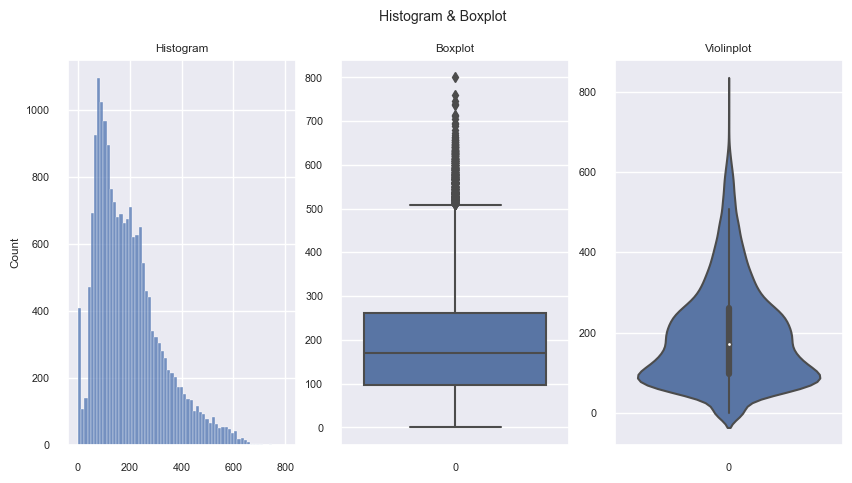

None

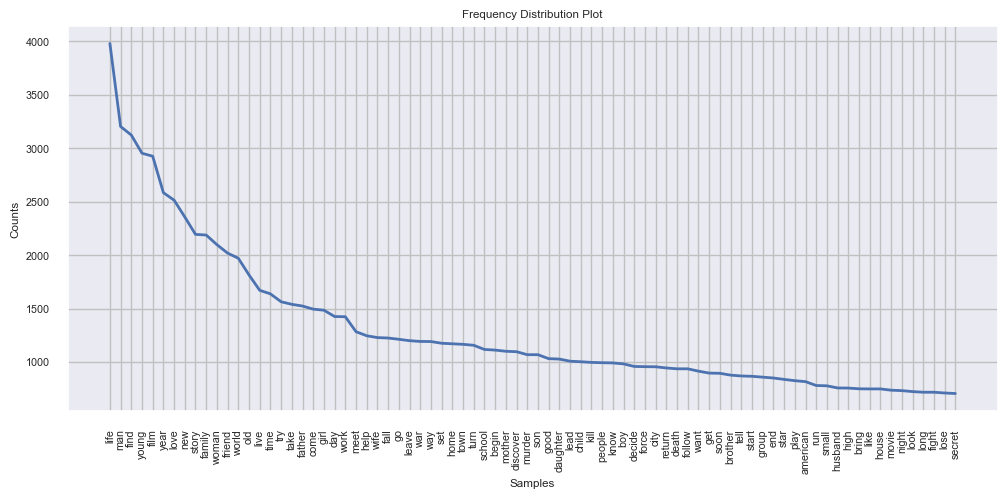

None

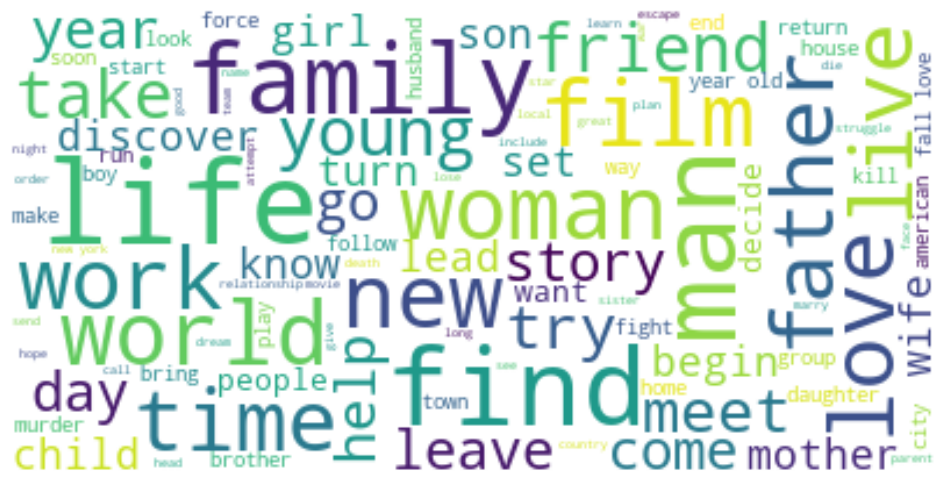

None

In [47]:
try:
    pkl_filename = f'resources/corpus_cleaned_0401.pkl'
    corpus = pickle.load(open(pkl_filename, 'rb'))
except:
    corpus = standardize(df.overview)
    pickle.dump(corpus, open(pkl_filename, 'wb'))
finally:
    display(corpus.head(5))
    display(summarize_data_lenght(data=corpus))
    display(frequency_dist(data=corpus))
    display(word_cloud(data=corpus))


In [48]:
# TfidfVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
# Palabras con más importancia (probar varias opciones)
vectorizer = TfidfVectorizer()   # TfidfVectorizer, CountVectorizer
vector = vectorizer.fit_transform(corpus[:20000])
vector.shape


(18945, 40590)

Vocabulary.

In [49]:
vocabulary = vectorizer.vocabulary_
display(list(vocabulary.items())[:10])
del vocabulary


[('family', 11779),
 ('wedding', 38941),
 ('reignite', 29453),
 ('ancient', 1201),
 ('feud', 12123),
 ('door', 9766),
 ('neighbor', 24509),
 ('fishing', 12351),
 ('buddy', 4616),
 ('john', 18138)]

Vectors.

In [50]:
display(vector.shape)
display(vector)


(18945, 40590)

<18945x40590 sparse matrix of type '<class 'numpy.float64'>'
	with 490044 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [51]:
print(corpus[0])
vectorizer_df = pd.DataFrame(data=vectorizer.transform([corpus[0]]).toarray(),
                             columns=vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(vectorizer_df[corpus[0].split()])

del vectorizer_df


family wedding reignite ancient feud door neighbor fishing buddy john max sultry italian divorcée open restaurant local bait shop alarm local worry scare fish away interested seafood cook hot time max


,family,wedding,reignite,ancient,feud,door,neighbor,fishing,buddy,john,...,worry,scare,fish,away,interested,seafood,cook,hot,time,max
0,0.087888,0.147879,0.220517,0.150661,0.191852,0.154902,0.147443,0.18101,0.1651,0.130312,...,0.191852,0.197088,0.184346,0.119312,0.169075,0.254419,0.179002,0.154332,0.093024,0.341562


Compute the cosine similarity matrix. `linear_kernel` is the same as `cosine_similarity`.

In [52]:
cosine_sim = cosine_similarity(vector, vector)
cosine_sim.shape


(18945, 18945)

In [53]:
def recommend_items_by_item(id, n):
    # Se obtiene la posición a partir del índice
    idx = df.index.get_loc(id)

    # Se obtienen las similitudes
    sim_scores = enumerate(cosine_sim[idx])

    # Se ordenan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Se obtienen los elementos con mejor similitud
    sim_scores = sim_scores[1:n+1]

    # Se obtiene las posiciones
    item_idxs = [i[0] for i in sim_scores]

    rec = df.iloc[item_idxs][['title', 'overview']]

    # Add scores
    rec['score'] = [i[1] for i in sim_scores]

    return rec


In [54]:
# @interact(id=df.index.sort_values())  # Todos
@interact(item_id=[12021, 10779, 4756])    # Recomendados
def _(item_id):
    item_filter = df.loc[item_id]

    print('Title:', item_filter.title)
    print('Overview:', item_filter.overview)

    display(recommend_items_by_item(id=item_id, n=20))


interactive(children=(Dropdown(description='item_id', options=(12021, 10779, 4756), value=12021), Output()), _…

## Collaborative Filtering

### User-Based

In [55]:
def users_items_based_collaboration_filtering(user_ratings_pivot):
    recommender_arr = np.zeros(user_ratings_pivot.shape)

    user_ratings_arr = user_ratings_pivot.to_numpy()

    row_len = user_ratings_pivot.shape[0]
    bar = ProgressBar(maxval=row_len).start()

    for u in range(0, row_len):
        user = user_ratings_arr[u]

        # Se filtra la matriz con los recursos utilizados por el usuario actual
        items_pos = np.argwhere(user != 0).reshape(-1)

        # Ningún recurso ha sido utilizado el usuario actual
        if len(items_pos) == 0:
            continue

        user_ratings = user_ratings_arr[:, items_pos]

        # Se calculan las similitudes entre el usuario actual y todos los usuarios
        ratings = user_ratings[u].reshape(1, -1)
        cosine_sim = cosine_similarity(ratings, user_ratings).reshape(-1, 1)

        # Se cambia a 0 la similitud entre el usuario actual con él mismo.
        cosine_sim[u][0] = .0

        # Se filtra la matriz con los recursos no utilizados por el usuario actual
        items_pos = np.argwhere(user == 0).reshape(-1)
        user_ratings = user_ratings_arr[:, items_pos]

        # Se genera una mask representando por una matriz con 1 si los usuarios ya han utilizado el recurso
        mask_user_ratings = np.where(user_ratings > .0, 1, 0) * cosine_sim

        # Se multiplica por la similaridad
        user_ratings = np.multiply(user_ratings, cosine_sim)

        # Se realizan las sumatorias
        user_ratings = np.sum(user_ratings, axis=0)
        mask_user_ratings = np.sum(mask_user_ratings, axis=0)

        # Para evitar las divisiones por 0
        mask_user_ratings = np.where(mask_user_ratings == 0, sys.float_info.min, mask_user_ratings)

        # Se calculan las recomendaciones
        recommendation = user_ratings / mask_user_ratings

        # Se actualizan solo las recomendaciones de los recursos no utilizados aún por el usuario actual
        recommender_arr[u, items_pos] = recommendation

        bar.update(u)

    bar.finish()

    recommender_arr = np.around(recommender_arr, 1)

    return pd.DataFrame(data=recommender_arr, index=user_ratings_pivot.index, columns=user_ratings_pivot.columns)


In [56]:
def collaborative_filtering_recomm(recommender_df):
    @interact(user_id=recommender_df.index)
    def _(user_id):
        for source in [recommender_df, user_ratings_pivot.T]:
            recommend_items_by_user = pd.DataFrame(columns=['title', 'overview', 'score'])

            ratings = source.loc[user_id].copy()

            for _ in range(0, 20):
                item_id = ratings.idxmax()

                title, overview = df.loc[item_id, ['original_title', 'overview']]
                score = ratings[item_id]
                recommend_items_by_user.loc[item_id] = {'title': title, 'overview': overview, 'score': score}

                ratings[item_id] = .0

            display(recommend_items_by_user)


In [57]:
recommender_df = users_items_based_collaboration_filtering(user_ratings_pivot.T)
recommender_df.head()


100% |########################################################################|


,0,1,2,3,4,5,6,7,8,9,...,46381,46382,46386,46393,46394,46395,46397,46400,46402,46413
1,0.0,3.8,3.2,2.7,2.2,3.1,3.8,3.1,3.2,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.9,3.4,2.9,2.5,3.1,3.8,3.3,3.9,3.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.9,3.3,2.9,2.4,3.1,3.9,3.2,3.8,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.9,3.3,2.9,2.4,3.1,3.8,3.2,3.7,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.9,3.3,0.0,2.4,3.2,3.8,3.2,3.8,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
collaborative_filtering_recomm(recommender_df)


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

### Items-Based

In [59]:
recommender_df = users_items_based_collaboration_filtering(user_ratings_pivot)
recommender_df.head()


100% |########################################################################|


,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.7,3.6,3.7,4.5,3.8,3.2,0.0,4.0,0.0,3.8,...,3.5,0.0,0.0,3.4,3.1,3.5,4.3,3.6,0.0,0.0
2,2.7,3.5,3.6,4.4,3.9,3.2,3.5,4.0,3.9,3.7,...,0.0,3.9,3.9,0.0,3.0,3.5,4.3,3.6,3.8,4.0
3,2.7,3.5,3.6,4.4,0.0,3.2,3.5,4.0,3.9,3.7,...,3.4,3.9,3.9,0.0,3.0,3.5,4.3,3.6,3.9,4.0
4,2.7,3.5,3.7,4.5,3.9,3.4,3.5,4.0,3.9,3.6,...,3.5,3.9,3.9,3.4,3.0,3.5,4.4,3.7,3.8,4.1


In [60]:
collaborative_filtering_recomm(recommender_df.T)


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

### K Nearest Neighbor

In [61]:
user_ratings_pivot


,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute').fit(user_ratings_pivot)
distances, indices = knn.kneighbors(user_ratings_pivot)


<Axes: >

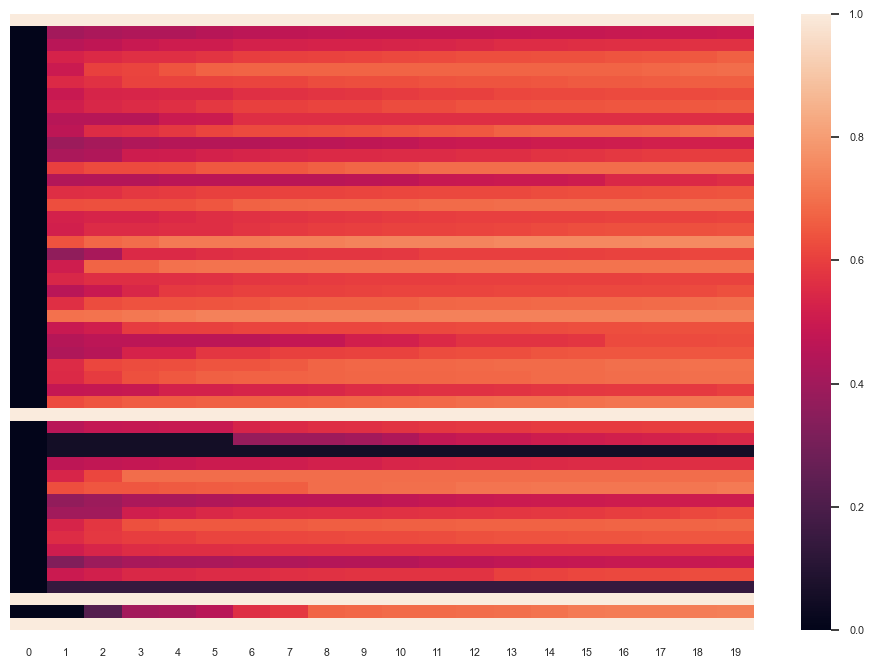

In [63]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.heatmap(data=distances[:50], annot=False, yticklabels=False)


In [64]:
@interact(item_id=user_ratings_pivot.index)
def _(item_id):
    # Se obtiene el índice del ítem
    item_idx = user_ratings_pivot.index.tolist().index(item_id)

    # Indices de los items similares
    items_sim = indices[item_idx].tolist()

    # Distancia entre los items similares y el item actual
    items_dist = distances[item_idx].tolist()

    if all(x == 1 for x in items_dist):
        print('No similarities...')
        return

    # Posición del item actual (Casi siempre es 0, pero se realiza el cálculo de todas formas)
    item_sim_idx = items_sim.index(item_idx)

    # Se elimina el item actual de la lista de similitudes
    items_sim.remove(item_idx)

    # Se elimina la distancia del item actual con el mismo (siempre será 0)
    items_dist.pop(item_sim_idx)

    items_idx = user_ratings_pivot.iloc[items_sim].index

    res_filter = df.loc[item_id]
    print('Title:', res_filter.title)

    rec = df.loc[items_idx, ['original_title']]
    rec['distance'] = items_dist
    display(rec)


interactive(children=(Dropdown(description='item_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

### K Nearest Neighbor (Surprise)

In [65]:
user_ratings_df = user_ratings_pivot.T.reset_index().melt(id_vars=['index'], var_name='item_id', value_name='rating')
user_ratings_df.rename(columns={'index': 'user_id'}, inplace=True)
user_ratings_df.head()


,user_id,item_id,rating
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0
3,4,0,0.0
4,5,0,0.0


In [66]:
min_scale, max_scale = user_ratings_df.rating.min(), user_ratings_df.rating.max()
reader = Reader(line_format='user item rating', rating_scale=(min_scale, max_scale))
surprise_set = Dataset.load_from_df(user_ratings_df, reader).build_full_trainset()

print(f"Total {surprise_set.n_users} users and {surprise_set.n_items} items in surprise_set. \n")

knn_surprise = KNNBasic()
knn_surprise.fit(surprise_set)


Total 671 users and 18945 items in surprise_set. 

Computing the msd similarity matrix...
Done computing similarity matrix.


In [67]:
def surprise_user_recomm():
    @interact(user_id=user_ratings_pivot.columns)
    def _(user_id):
        # recomendadas
        predictions = [knn_surprise.predict(uid=user_id, iid=item_id) for item_id in user_ratings_pivot.index]

        pred_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        pred_df.sort_values(by='est', ascending=False, inplace=True)

        display(pred_df)
        display(pred_df.iid.apply(lambda x: df.loc[x].original_title))

        # vistas
        item_idx = user_ratings_pivot.loc[:, user_id].where(lambda x: x != 0).dropna().index
        display(df.loc[item_idx].original_title)


In [68]:
surprise_user_recomm()


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [69]:
def surprise_item_recomm():
    @interact(item_id=user_ratings_pivot.index)
    def _(item_id):
        predictions = [knn_surprise.predict(uid=user_id, iid=item_id) for user_id in user_ratings_pivot.columns]

        pred_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        pred_df.sort_values(by='est', ascending=False, inplace=True)

        display(pred_df[:20])
        

In [70]:
surprise_item_recomm()


interactive(children=(Dropdown(description='item_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

### Reducing Dimensionality (Surprise)

In [71]:
svd_surprise = SVD()
svd_surprise.fit(surprise_set)


In [72]:
surprise_user_recomm()


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [73]:
surprise_item_recomm()


interactive(children=(Dropdown(description='item_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

### Non-negative Matrix Factorization (Surprise)

In [74]:
nmf_surprise = NMF()
nmf_surprise.fit(surprise_set)


In [75]:
surprise_user_recomm()


interactive(children=(Dropdown(description='user_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [76]:
surprise_item_recomm()


interactive(children=(Dropdown(description='item_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

# Model-Based

In [77]:
# TODO


# Hybrid-Based

In [78]:
# TODO
